# Hamiltonian simulation with Gray code encoding - statevector simulator

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
import scipy
from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *

## Playing with Pauli and WeightedPauli operators

In [2]:
import itertools

## H is always in qiskit order (right to left)
## String form is also in that order 

## State vector results in order [00,01,10,11]

n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}


In [3]:
def commutes(a,b):
    """
    Returns true if two operators commute
    
    input:
        a,b (str) : Pauli operators.  Must be "X", "Y", "Z", "I"
    """
    #Todo add raise error if a[i] not in allowed pauli set
    does_commute=True
    for i in range(len(a)):
        ## If ai or bi are identity then ith paulis will commute 
        if a[i]=='I' or b[i]=='I':
            continue
        
        ## if ai != bi then they won't commute 
        if a[i]!=b[i]:
            does_commute=False
            break

    return does_commute


def get_pauli_terms(weighted_pauli):
    """
    Extract out individual paul terms 
    
    Input:
        weighted_pauli ():
        
    Return
        terms (dictionary) : dictionary of {label:coef} for each pauli term. 
                label is pauli string
    """
    terms={}
    for term in weighted_pauli.to_dict()['paulis']:
        label=term['label']
        coef=term['coeff']['real']+1j*term['coeff']['imag']
        terms[label]=coef
    return terms

def get_sigma_pauli_terms(n_qubits):
    """Get all possible pauli operators for given number of qubits """ 
    pauli_strings=["I","X","Y","Z"]
    pauli_product_strings=list(map(lambda x : "".join(x),list(itertools.product(*[pauli_strings for i in range(n_qubits)]))))

    ## Extract out pauli terms of odd number of Y 
    paulis=[]
    for string in pauli_product_strings:
        if string.count("Y")%2==1:
            paulis.append(Pauli.from_label(string))

    sigmas=[]
    for pauli in paulis:
        sigma=[(1.0,pauli)]
        sigmas.append(WeightedPauliOperator(sigma))

    return sigmas


def H_weighted_paulis(H):
    H_pairs=[(v, Pauli.from_label(k)) for (k, v) in list(H.pauli_coeffs.items())]
    return WeightedPauliOperator(H_pairs)   
    
    
def b_terms(H,sigmas):
    b_pauli_terms=[]
    H_paulis=H_weighted_paulis(H)
    for sigma in sigmas:
        product=1j*(H_paulis.__mul__(sigma)-sigma.__mul__(H_paulis))
        product.chop(1e-5)
        terms=get_pauli_terms(product)
        b_pauli_terms.append(terms)
    return b_pauli_terms

## define S array
def S_terms(sigmas):
    d=len(sigmas)
    S={}
    for i in range(d):
        sigma1=sigmas[i]
        for j in range(d):
            sigma2=sigmas[j]
            product=sigma1.__mul__(sigma2)
            S[(i,j)]=get_pauli_terms(product)
    return S



def get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms):
    """
    Get intersection of pauli terms needed to compute S and b
    
    Only useful if not computing all possible gate combinations
    """
    ## Initialize set with pauli terms in Hamiltonian
    pauli_set=set(H.pauli_coeffs.keys())
    
    ## Add b 
    for bI in b_pauli_terms:
        pauli_set.update(bI.keys())

    ## Add S
    for term in S_pauli_terms.values():
            pauli_set.update(term.keys())

    return pauli_set


def compute_expectation_value(pauli,meas_results):
    pauli_list = list(pauli)
    n_qubits = len(pauli_list)
    expectation_value=0.0
    for basis_state in meas_results.keys():
        num_z_and_1 = [-1 if (basis_state[bit_idx] == '1' and pauli_list[bit_idx] != 'I') else 1 for bit_idx in range(n_qubits)]
        eigenvalue = reduce(lambda x, y: x*y, num_z_and_1)
        expectation_value+=eigenvalue*meas_results[basis_state]

    return expectation_value

def get_commuting_sets(paulis):
    """
    Get a dictionary of commuting sets.  
    
    Key for each set is term with fewest number of idenity operators 
    and thus provides key for measurement basis
    
    input:
        paulis (list<str>) : list of pauli terms
    
        
    """
    commuting_array=[]
    paulis=list(paulis)
    for p1 in paulis:
        does_commute=False
        for i in range(len(commuting_array)):
            p_set=commuting_array[i]
            for p2 in p_set:
                does_commute=commutes(p1,p2)
                if not does_commute:
                    break
            if does_commute:
                commuting_array[i].append(p1)
                break
        if not does_commute:
            commuting_array.append([p1])

    ## identify pauli which will define measurement basis
    commuting_sets={}
    n_qubits=len(paulis[0])
    for p_set in commuting_array:
        minI=n_qubits
        identitfier=None
        for p in p_set:
            numI=p.count("I")
            if numI < minI:
                minI=numI
                identifier=p
        commuting_sets[identifier]=p_set
    return commuting_sets



In [5]:
def initialize_circuit(q,c,initial_state="zeros"):
    """
    Initialize circuit.  
    
    input:
        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        initial_state(str or np.array) : initial state of circuit
            "zeros" (str,default) : starting state is qubit state with all qubits in zero state
            "uniform" (str) : Uniform superposition of all qubit states 
             array(np.array) : normalized array of len(2**n_qubits)
    returns
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : initialized quantum circuit
    """    

    if initial_state is None:
        initial_state="zeros"
        
    if isinstance(initial_state, str):
        if initial_state=="zeros":
            circuit = QuantumCircuit(q,c)

        elif initial_state=="uniform":
            circuit = QuantumCircuit(q,c)
            circuit.h(q)
        else:

            print(initial_state, "not currently valid option")
            sys.exit(f"{initial_state} not currently valid option")
    else:
        circuit = QuantumCircuit(q,c)
        circuit.initialize(initial_state,q)
    return circuit


def get_evolution_circuit(q,A_set,circuit):
    """
    Append evolution exp(-iAt) onto circuit for each time step t
    
    input:
        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        A_set () : List of Weighted Pauli operators by which the circuit is evolved at each timestep
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : quantum circuit 

    return
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : updated quantum circuit
    """

    for A in A_set: 
        #Append next step to circuit for each A
        circuit += A.evolve(
            None, evo_time=1, num_time_slices=1,
            quantum_registers=q
            )
    return circuit  

def get_measurement_circuit(q,c,circuit,set_id):
    """
    Append gates to transform qubit states to measurement basis 
    
    input 
        q (qiskit.circuit.quantumregister.QuantumRegister) : qubits
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : quantum circuit 
        set_id (str) : pauli operator to be measured
    return
        circuit (qiskit.circuit.quantumcircuit.QuantumCircuit) : updated quantum circuit        
    """
    ## Reverse order to gates are applied right to left
    id=set_id[::-1]
    
    for qubit_idx in range(len(set_id)):
        pauli=id[qubit_idx]
        if pauli == 'X':
            circuit.h(q[qubit_idx])
        elif pauli == 'Y':
            circuit.sdg(q[qubit_idx])
            circuit.h(q[qubit_idx])
    
    circuit.measure(q,c)
    
    return circuit


def run_circuit_statevector(n_qubits,A_set,initialization=None):
        ## Initalize circuit
        q = QuantumRegister(n_qubits)
        c = ClassicalRegister(n_qubits)
        
        circuit=initialize_circuit(q,c,initial_state=initialization)

        ## If A_set not t, then evolve cirucit using previously computed A matrices stored in A_set
        if len(A_set)>0:
            circuit=get_evolution_circuit(q,A_set,circuit)

        ## Execute circuit
        job = execute(circuit, Aer.get_backend("statevector_simulator"))
        
        return job.result().get_statevector(circuit)        

    
def run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=1024,initialization=None):
        ## Initalize circuit
        q = QuantumRegister(n_qubits)
        c = ClassicalRegister(n_qubits)
        
        circuit=initialize_circuit(q,c,initial_state=initialization)

        ## If A_set not t, then evolve cirucit using previously computed A matrices stored in A_set
        if len(A_set)>0:
            circuit=get_evolution_circuit(q,A_set,circuit)
        
        ## Rotate to measurement basis 
        circuit=get_measurement_circuit(q,c,circuit,pauli_id)       
        
        ## Execute circuit
        job = execute(circuit, Aer.get_backend("qasm_simulator"),shots=n_shots)
        
        ## Get counts
        counts= job.result().get_counts(circuit)

        ##normalize counts
        for state in counts:
            counts[state]=counts[state]/n_shots
        
        return counts



##testing state initialization 
if False:    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(n_qubits)
#     init=np.random.uniform(0,1,2**n_qubits)
#     init=init/np.sqrt(init.dot(init))

    print("initialization vector",init)
    print(init.dot(init))

    circuit = initialize_circuit(q,c,initial_state=init)
    backend = 'statevector_simulator'
    
    job = execute(circuit, Aer.get_backend(backend),shots=n_shots)
    
    state_vector=job.result().get_statevector(circuit)
    counts = job.result().get_counts(circuit)
    n_shots = sum(counts.values())
    print("state vector : ",state_vector)
    print("num shots :",n_shots)
    print("counts :",counts)
    print(sum(counts.values()))
    
    print()

A_set=[]
pauli_id="I"*n_qubits

state_vector=run_circuit_statevector(n_qubits,A_set,initialization=None)


counts=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=10000,initialization=None)
vec=[]
for state in counts:
    vec.append(np.sqrt(counts[state]))
    
print(state_vector)
print(counts)
print(vec)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
{'00': 1.0}
[1.0]


In [54]:
n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
# print(H.N_qubits)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}


In [7]:
## vector of WeightedPauliOperators representing vector Sigma

## Get list of sigmas (all pauli terms with odd number Y gates)
sigmas=get_sigma_pauli_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p],p[::-1])
    


XX ['II', 'IX', 'XI', 'XX'] XX
XY ['IY', 'XY'] YX
XZ ['IZ', 'XZ'] ZX
YX ['YI', 'YX'] XY
YY ['YY'] YY
YZ ['YZ'] ZY
ZX ['ZI', 'ZX'] XZ
ZY ['ZY'] YZ
ZZ ['ZZ'] ZZ


In [92]:
def A_pauli_operator(S_pauli_terms,b_pauli_terms,expectation_values,energy,A_threshold):
        
    ## compute normalization coef C=1-2*E*delta_times
    ## Using TM approx: 1/sqrt(C) approx 1-E*delta_time
    Ccoef=1-delta_time*energy
    
    ## compute b
    num_sigmas=len(sigmas)
    b=np.zeros(num_sigmas)
    for sigma_idx in range(num_sigmas):
        bI=b_pauli_terms[sigma_idx]
        for term in bI:
            b[sigma_idx]+=bI[term]*expectation_values[term]

    b=b/Ccoef
          
    ## Comput S
    Smatrix=np.asmatrix(np.zeros((num_sigmas,num_sigmas)))
    for i in range(num_sigmas):
        for j in range(num_sigmas):
            Sij=S_pauli_terms[(i,j)]
            for term in Sij:
                #(S+S^T) gives rise to factor of 2
                Smatrix[i,j]+=2*Sij[term]*expectation_values[term] 

    ## Solve for a in (S+S^T)a=b
    a,_,_,_=lstsq(Smatrix,b,cond=A_threshold)
    if verbose==True:
        print("Smatrix")
        print(Smatrix)
        print("b\n",b)
        print("a\n",a)
    
    ## Construct A from a
    identity_string="I"*n_qubits

    ##Null initialize A with 0.0*Identity. 
    A=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])

    for i in range((len(sigmas))):
        A+=delta_time*a[i]*sigmas[i]

    if verbose==True:       
        print("t=",t)
        print("-----------------------------------------")

        print("wavefunction\n",wavefunction)        
        print("\nA operator")
        print(A.print_details())
        
        A_pauli_terms=get_pauli_terms(A)
        Amatrix=reduce(lambda x,y: x+y,[A_pauli_terms[term]*get_pauli_matrix(term) for term in A_pauli_terms])
        print(Amatrix)
        print("-----------------------------------------")

    return A

def run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
    n_shots=10000 ## Set to allowed number of shots at IBMQ

    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=get_sigma_pauli_terms(n_qubits)

    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
      
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))
    
    ## Zero initialize 
    A_set=[]
    a=np.zeros(len(sigmas))
    Energies=np.zeros(num_iterations)

    ## for each time step, run circuit and compute A for the next time step
    for t in range(num_iterations):
    #     print("")
        expectation_values={}
        if backend=='statevector_simulator':
            ## Run circuit to get state vector
            psi=run_circuit_statevector(n_qubits,A_set,initialization=None)

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value

        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=n_shots,initialization=initialization)

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        for key in H_pauli:
            Energies[t]+=H_pauli[key]*expectation_values[key]

        ## Compute A
        A_set.append(A_pauli_operator(S_pauli_terms,b_pauli_terms,expectation_values,Energies[t],A_threshold))

        if isinstance(cstep,int):
            if t%cstep==0:
                A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
                for A in A_set:
                    A_combine+=A
                A_set=[A_combine]

    return Energies


In [93]:
from scipy.linalg import lstsq
import scipy as sp
#####################################       
# Prepare and run the evolution circuit
#####################################       

# num_iterations=30
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

backend = 'statevector_simulator'
sv_energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for threshold in [1,1e-1,1e-2]:
    backend = 'qasm_simulator'
    Energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold)
    Energy_table.append(Energies)



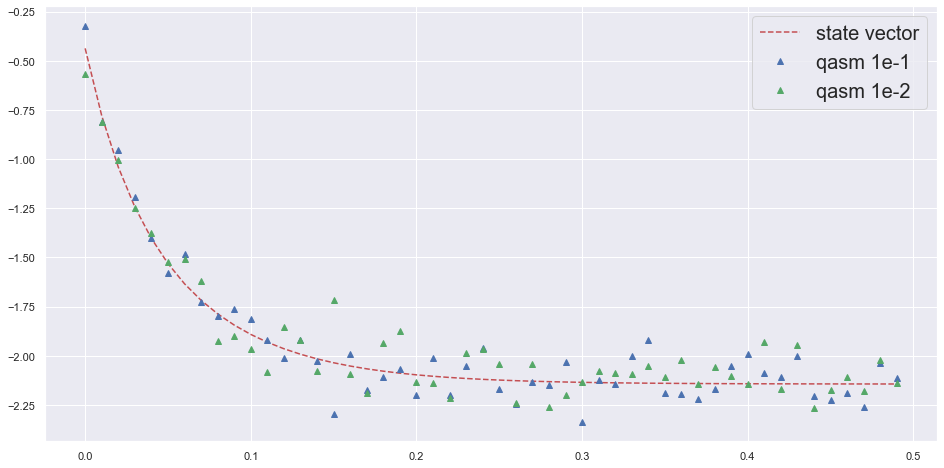

In [94]:
# num_iterations=100
# delta_time=0.01
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-1")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-2")
plt.legend(prop={'size': 20})

In [81]:
### Testing  time steps 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_time=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

# backend = 'statevector_simulator'
# sv_energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10)

for delta_time in [0.001,0.01,0.1]:
    backend = 'qasm_simulator'
    Energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2)
    Energy_table_time.append(Energies)



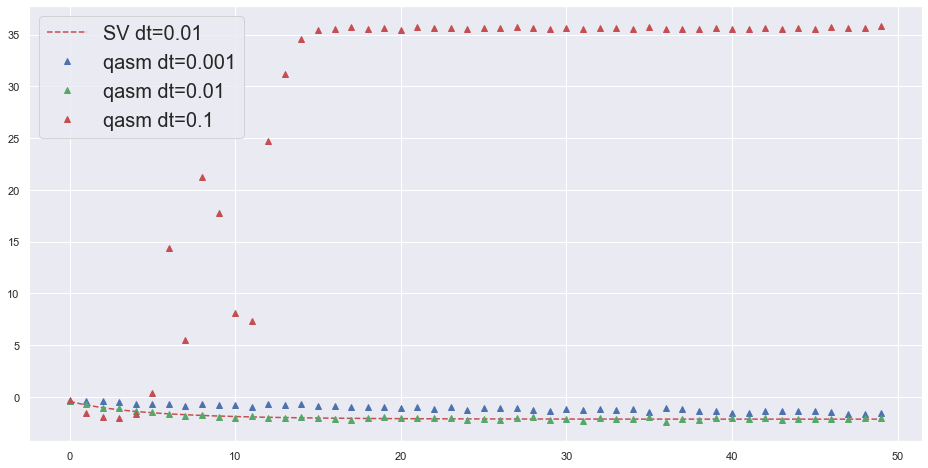

In [89]:
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,sv_energies,'r--',label="SV dt=0.01")
plt.plot(time,Energy_table_time[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time[2],'r^',label="qasm dt=0.1")
plt.plot()
plt.legend(prop={'size': 20})

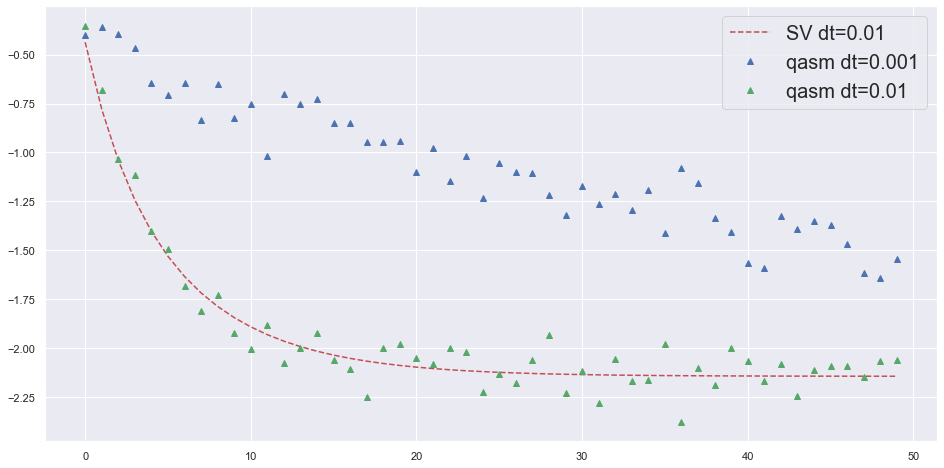

In [88]:
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,sv_energies,'r--',label="SV dt=0.01")
plt.plot(time,Energy_table_time[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time[1],'g^',label="qasm dt=0.01")
# plt.plot(time,Energy_table_time[2],'r^',label="qasm dt=0.1")
plt.plot()
plt.legend(prop={'size': 20})

In [115]:
## Combining A 
num_iterations=30
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="zeros"

Energy_table_step=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

for cs in range(0,num_iterations,5):
    if cs==0:
        cs=None
    Energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step.append(Energies)

0
5
10
15
20
25


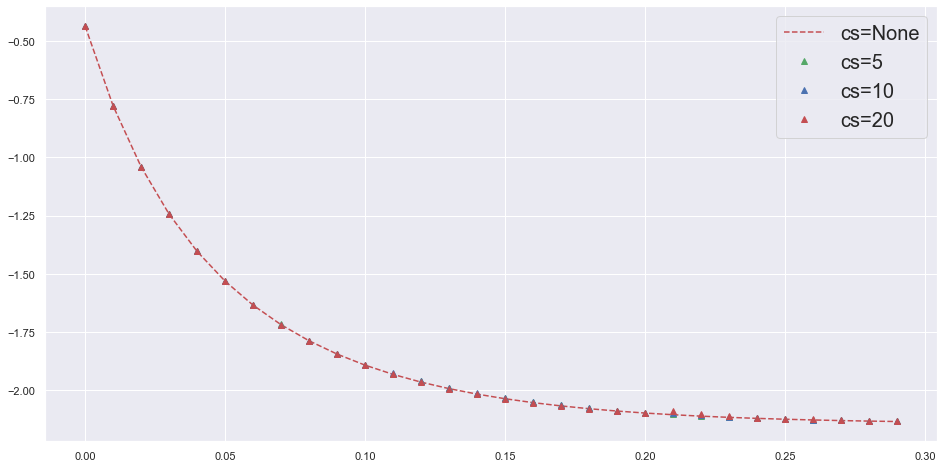

In [122]:
for cs in range(0,30,5):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[0.01*t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,Energy_table_step[0],'r--',label="cs=None")
plt.plot(time,Energy_table_step[1],'g^',label="cs=5")
plt.plot(time,Energy_table_step[2],'b^',label="cs=10")
plt.plot(time,Energy_table_step[4],'r^',label="cs=20")
plt.plot()
plt.legend(prop={'size': 20})

0
5
10
15
20
25


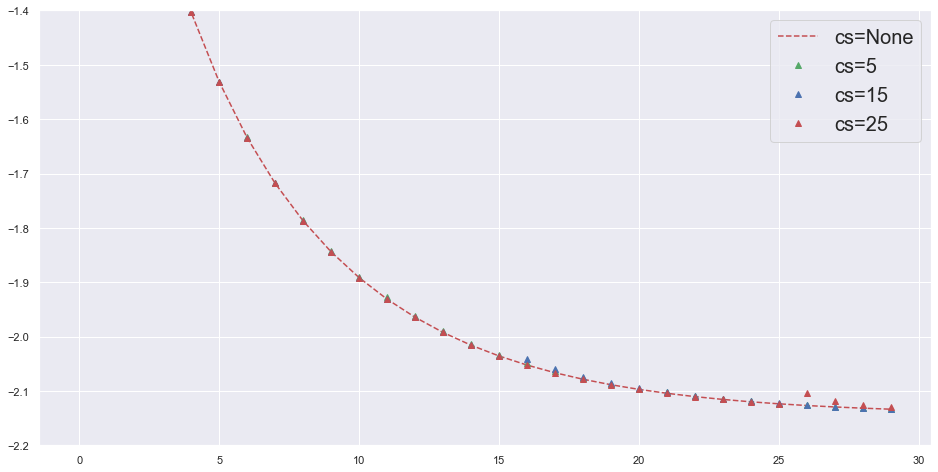

In [127]:
for cs in range(0,30,5):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[t for t in range(num_iterations)]
# plt.plot(time,sv_energies,'r--',label="state vector")
plt.plot(time,Energy_table_step[0],'r--',label="cs=None")
plt.plot(time,Energy_table_step[1],'g^',label="cs=5")
plt.plot(time,Energy_table_step[3],'b^',label="cs=15")
plt.plot(time,Energy_table_step[5],'r^',label="cs=25")
plt.ylim(-2.2,-1.4)
plt.plot()
plt.legend(prop={'size': 20})


In [128]:
## Combining A 
num_iterations=50
delta_time=0.01
verbose=False
backend = 'qasm_simulator'
initialization="zeros"

Energy_table_step_qasm=[]
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

for cs in range(0,num_iterations,5):
    if cs==0:
        cs=None
    Energies=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=cs)
    Energy_table_step_qasm.append(Energies)

0
5
10
15
20
25
30
35
40
45


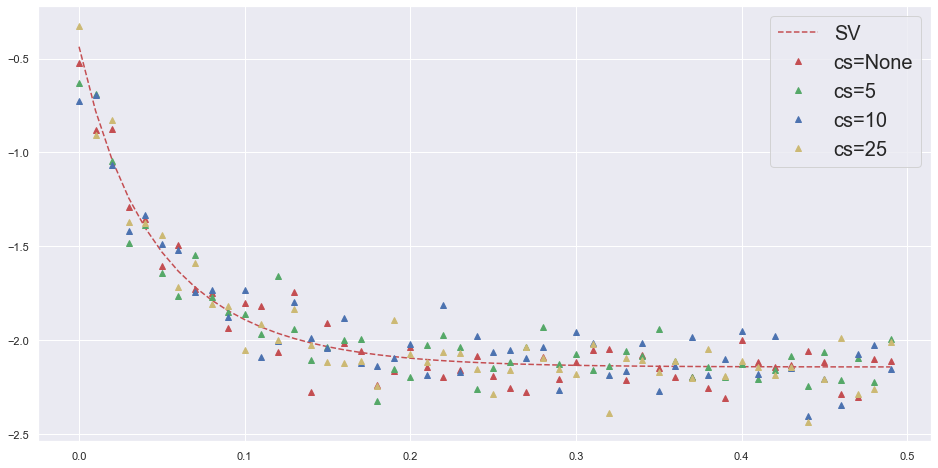

In [132]:
for cs in range(0,50,5):
    print(cs)
# num_iterations=100
# delta_time=0.01
time=[0.01*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=5")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=10")
plt.plot(time,Energy_table_step_qasm[5],'y^',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})

In [7]:
def unitary_evolution(A, t):
    return expm(-1j * A* t)

A_pauli_terms=get_pauli_terms(A)
for p in A_pauli_terms:
    print( p, A_pauli_terms[p])

# pp=[p[1] * get_pauli_matrix(p[0]) for p in H.pauli_coeffs.items()]
Amatrix=reduce(lambda x,y: x+y,[A_pauli_terms[term]*get_pauli_matrix(term) for term in A_pauli_terms])
print(Amatrix)
    
uniform_gc = 0.5 * np.array([[1], [1], [1], [1]])
wavefunction = unitary_evolution(Amatrix, t=time) @ uniform_gc
true_probabilities = (wavefunction * np.conj(wavefunction)).flatten()
print(wavefunction)
print(true_probabilities)

IY (0.0007045682525928991+0j)
XY (0.002820734443338741+0j)
YI (-0.00047639467664536316+0j)
YX (0.001736918953154769+0j)
YZ (-0.002163303040252517+0j)
ZY (-9.843387924034359e-05+0j)
[[0.+0.j         0.-0.00060613j 0.+0.0026397j  0.-0.00455765j]
 [0.+0.00060613j 0.+0.j         0.+0.00108382j 0.-0.00168691j]
 [0.-0.0026397j  0.-0.00108382j 0.+0.j         0.-0.000803j  ]
 [0.+0.00455765j 0.+0.00168691j 0.+0.000803j   0.+0.j        ]]
[[0.49936622+0.j]
 [0.49999962+0.j]
 [0.49886844+0.j]
 [0.50176094+0.j]]
[0.24936663+0.j 0.24999962+0.j 0.24886972+0.j 0.25176404+0.j]
